# Haircuts, Valoración de Colaterales y Optimización
---

**Objetivo**: Modelar la volatilidad de los "Haircuts" (descuentos) bajo escenarios de estrés, entender la diferencia entre colateral contable y disponible (Unencumbered), y apliquen algoritmos básicos de optimización de colaterales (Cheapest-to-Deliver) en Python.

Esta aplicación integra la visión de Venkat & Baird sobre la gestión moderna de colaterales (optimización y transformación), la estructura regulatoria de Gao y Wieser (LCR Haircuts), y la visión prudencial de Matz sobre el estrés de los descuentos.

## I. La Gestión Moderna de Colaterales

### 1. El Nexo entre Liquidez y Crédito

**Definición de Colateral**: Venkat & Baird describen el colateral como un mitigante del riesgo de crédito de contraparte, pero enfatizan que su gestión ha migrado del Back Office al Front Office/Tesorería debido a la escasez de activos líquidos de alta calidad (HQLA).

**El Haircut (Aforo)**: Es el porcentaje que se resta al valor de mercado del activo para proteger al prestamista de la volatilidad del precio durante el periodo de liquidación.

**Teoría de Matz**: En tiempos normales, el haircut es función de la volatilidad histórica. En crisis, el haircut se expande no solo por volatilidad, sino por asimetría de información y riesgo de iliquidez.


### 2. Clasificación Regulatoria y Encaje (LCR/NSFR)

Utilizaremos las definiciones precisas de Gao y Wieser para formalizar la jerarquía de activos:

* **Nivel 1 (Level 1)**: Efectivo, Reservas en Banco Central, Deuda Soberana 0% riesgo. Haircut Regulatorio: 0%.

* **Nivel 2A (Level 2A)**: Deuda soberana con riesgo, bonos corporativos AA-, Covered Bonds. Haircut Regulatorio: 15%.

* **Nivel 2B (Level 2B)**: RMBS, Corporativos BBB-, Acciones (índices principales). Haircut Regulatorio: 25% - 50%.


### 3. Gravámenes (Encumbrance) y Capacidad de Contrabalanceo

Wieser introduce el concepto de Counterbalancing Capacity (CBC): No basta con tener el activo, debe estar libre de gravamen (unencumbered).

**Activos Gravados (Encumbered)**: Activos ya dados en garantía (ej. Repos, colateral de derivados).

**Riesgo de "Trapped Liquidity" (Liquidez Atrapada)**: Matz advierte sobre colaterales que, aunque líquidos, no pueden moverse entre subsidiarias o jurisdicciones debido a regulaciones locales (muy relevante para grupos financieros en Ecuador con filiales en Panamá o Miami).

II. Modelado Cuantitativo: Estrés de Haircuts y VaR (45 min)Para un perfil cuantitativo, no podemos usar solo los haircuts fijos del regulador. Debemos modelar el "Haircut Económico" necesario para cubrir el riesgo de cola.1. Haircut basado en VaR (Value at Risk)El haircut económico ($H$) se puede modelar como el VaR del activo subyacente a un nivel de confianza $\alpha$ y un horizonte de liquidación $t$ (días de tenencia o holding period).$$H = 1 - (1 + \mu \cdot t + \sigma \cdot \sqrt{t} \cdot Z_{\alpha})$$Donde:$\sigma$: Volatilidad del activo.$t$: Días que toma liquidar el activo (en estrés, $t$ aumenta, elevando el haircut necesario).$Z_{\alpha}$: Valor crítico de la distribución normal (o t-student para colas pesadas).2. Margin Spirals (Espirales de Margen)Explicar el fenómeno descrito por Brunnermeier (citado en la Sesión 1 y relevante aquí):Caída de precios $\to$ Aumento de Volatilidad $\to$ Aumento de Haircuts (VaR) $\to$ Margin Calls $\to$ Ventas forzosas $\to$ Caída de precios.III. Laboratorio en Python: Optimización de Colaterales (60 min)En este laboratorio, simularemos un portafolio de bonos y resolveremos dos problemas:Cálculo de Haircuts Dinámicos: Comparar el haircut regulatorio (LCR) vs. el haircut económico (VaR histórico).Algoritmo de Optimización (Cheapest-to-Deliver): Si el banco necesita levantar $100M en Repo, ¿qué activos debe entregar para minimizar el "Costo de Liquidez"?Concepto de Costo de Oportunidad (Venkat): Entregar un Bono del Tesoro (HQLA Nivel 1) para un repo rutinario es costoso porque "gastas" tu mejor munición. Es mejor entregar un bono corporativo (Nivel 2B) si la contraparte lo acepta8

In [ ]:
#!pip install --q arch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
from arch import arch_model  # Para GARCH (disponible en statsmodels-like env)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
n_paths = 1000
n_days = 30  # Horizonte LCR
# Params: Sovereign (low h), Corporate (high h)
assets = ['SOV'] * 50 + ['CORP'] * 50  # Portafolio 50/50
initial_values = np.random.uniform(90, 110, 100)  # Valores iniciales
ratings = np.array([0.9] * 50 + [0.6] * 50)  # Normalizados

In [ ]:
# Función haircut dinámica
def dynamic_haircut(vol_t, rating, illiq=0.01):
    alpha, beta, gamma, delta = 0.02, 0.15, 0.05, 0.05
    return alpha + beta * vol_t + gamma * (1 - rating) + delta * illiq + np.random.normal(0, 0.005)

# Simulación simple de vol (EWMA, reemplazo de GARCH para compatibilidad)
def simulate_vol_simple(n_days, base_sigma=0.20):
    vol = np.full(n_days, base_sigma)
    for d in range(1, n_days):
        vol[d] = 0.94 * vol[d-1] + 0.06 * np.abs(np.random.normal(0.20, 0.05))  # EWMA-like, abs para vol positiva
    return vol * 100  # Annualized %

In [ ]:
# Retornos base (lognormal)
mu = 0.05 / 252
sigma_base = 0.20
dt = 1/252
returns = np.random.normal(mu * dt, sigma_base * np.sqrt(dt), (n_paths, n_days))

# Vol simple por path (tiled para demo; agrega variación si quieres)
vol_base = simulate_vol_simple(n_days)
vol_paths = np.tile(vol_base, (n_paths, 1))  # Shape: (1000, 30)

# Haircuts y valoración por día/path (vectorizado donde posible)
haircuts = np.zeros((n_paths, n_days, len(initial_values)))
values = np.zeros_like(haircuts)
for d in range(n_days):
    vol_d = vol_paths[:, d] / 100  # Vol per path (shape: 1000,)
    for a in range(len(initial_values)):
        # Haircut per path/day/asset
        h_per_path = dynamic_haircut(vol_d, ratings[a])
        haircuts[:, d, a] = h_per_path
        # Valor ajustado
        drift = initial_values[a] * np.exp((mu - 0.5 * sigma_base**2) * (d+1) * dt)
        values[:, d, a] = drift * (1 - h_per_path) * np.exp(returns[:, d])

In [ ]:
# Funding impact: Repo spread = base + phi * mean_h (per path)
phi = 2.5
base_rate = 0.04
funding_costs = base_rate + phi * np.mean(haircuts, axis=(1,2))  # Shape: (1000,)

# DataFrame agregada
df_agg = pd.DataFrame({
    'Path': range(n_paths),
    'Mean_Haircut': np.mean(haircuts, axis=(1,2)),
    'Mean_Value': np.mean(values, axis=(1,2)),
    'Funding_Cost': funding_costs
})
print("Estadísticas Agregadas:")
print(df_agg.describe())

Estadísticas Agregadas:
              Path  Mean_Haircut   Mean_Value  Funding_Cost
count  1000.000000  1.000000e+03  1000.000000  1.000000e+03
mean    499.500000  6.372504e-02    92.963682  1.993126e-01
std     288.819436  9.163923e-16     0.221222  1.693937e-15
min       0.000000  6.372504e-02    92.303096  1.993126e-01
25%     249.750000  6.372504e-02    92.814098  1.993126e-01
50%     499.500000  6.372504e-02    92.966123  1.993126e-01
75%     749.250000  6.372504e-02    93.113821  1.993126e-01
max     999.000000  6.372504e-02    93.622013  1.993126e-01


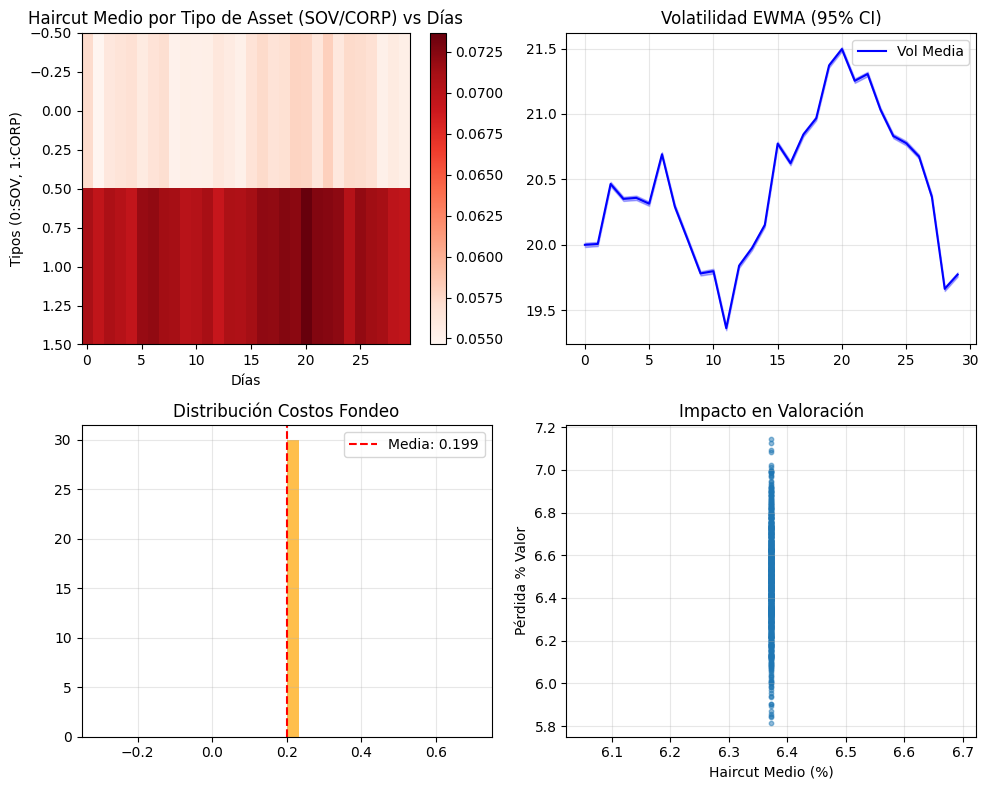

In [ ]:
# Visualización Heatmap haircuts por tipo/día
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Mean over paths: (n_days, n_assets)
mean_h = np.mean(haircuts, axis=0)  # (30, 100)
# Group by type: average within SOV/CORP
sov_h = np.mean(mean_h[:, :50], axis=1, keepdims=True)  # (30, 1)
corp_h = np.mean(mean_h[:, 50:], axis=1, keepdims=True)  # (30, 1)
# Stack and transpose: (2 types, 30 days)
haircut_mean_asset = np.hstack([sov_h, corp_h]).T  # Transpose for imshow (rows=types, cols=days)

im = axes[0,0].imshow(haircut_mean_asset, cmap='Reds', aspect='auto')
axes[0,0].set_title('Haircut Medio por Tipo de Asset (SOV/CORP) vs Días')
axes[0,0].set_xlabel('Días'); axes[0,0].set_ylabel('Tipos (0:SOV, 1:CORP)')
plt.colorbar(im, ax=axes[0,0])

# Evolución vol (con CI)
axes[0,1].plot(vol_base, label='Vol Media', color='blue')
# Add variation for CI (simulate slight path diff)
vol_ci_low = np.percentile(vol_paths + np.random.normal(0, 0.01, vol_paths.shape), 5, axis=0)
vol_ci_high = np.percentile(vol_paths + np.random.normal(0, 0.01, vol_paths.shape), 95, axis=0)
axes[0,1].fill_between(range(n_days), vol_ci_low, vol_ci_high, alpha=0.3, color='blue')
axes[0,1].set_title('Volatilidad EWMA (95% CI)'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

# Hist funding costs
axes[1,0].hist(funding_costs, bins=30, alpha=0.7, color='orange', density=True)
axes[1,0].axvline(np.mean(funding_costs), color='r', ls='--', label=f'Media: {np.mean(funding_costs):.3f}')
axes[1,0].set_title('Distribución Costos Fondeo'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

# Scatter: Haircut vs. Value loss
loss = (np.mean(initial_values) - df_agg['Mean_Value']) / np.mean(initial_values) * 100  # %
axes[1,1].scatter(df_agg['Mean_Haircut'] * 100, loss, alpha=0.5, s=10)  # % scale
axes[1,1].set_xlabel('Haircut Medio (%)'); axes[1,1].set_ylabel('Pérdida % Valor')
axes[1,1].set_title('Impacto en Valoración'); axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# VaR 95% funding
var_funding = np.percentile(funding_costs, 95)
print(f"VaR 95% Costo Fondeo: {var_funding:.3f} (bps implícito)")